# Detecting Anomalous Activity of a Ship's Engine

A poorly maintained ship engine in the supply chain industry can lead to inefficiencies, increased fuel consumption, higher risks of malfunctions, and potential safety hazards. The real data set can be used to identify anomalous activity in a ship’s engine functionality (Devabrat,  2022). For additional context, typically speaking, anomalies would make up a minority of the data points (i.e., about 1% to 5% of the data points would be anomalies).

The data set contains six important features continuously monitored to evaluate the engine's status as ‘good’ or ‘bad’. These features are:
- **Engine rpm (revolutions per minute):** A high rpm indicates the engine is operating at a higher speed than designed for prolonged periods, which can lead to overheating, excessive wear, and eventual failure. A low rpm could signal a lack of power, issues with fuel delivery, or internal mechanical problems.
- **Lubrication oil pressure:** Low lubrication oil pressure indicates insufficient lubrication, leading to increased friction, overheating, and engine damage. A high lubrication oil pressure could signal a blockage in the oil delivery system, potentially causing seal or gasket failure.
- **Fuel pressure:** High fuel pressure can cause poor engine performance and incomplete combustion, indicating fuel pump or filter issues. A low fuel pressure may result in excessive fuel consumption, poor emissions, or damage to the fuel injectors.
- **Coolant pressure:** Low coolant pressure indicates a potential leak in the cooling system or a coolant pump failure, risking engine overheating. A high coolant pressure could be a sign of a blockage in the cooling system or a failing head gasket, which can also lead to overheating.
- **Lubrication oil temperature:** High lubrication oil temperature suggests the oil is overheating, which can degrade its lubricating properties and lead to engine damage. A low lubrication oil temperature may indicate it is not reaching its optimal operating temperature, potentially causing inadequate lubrication.
- **Coolant temperature:** High coolant temperature signals overheating, which various issues, including a failed thermostat, coolant leak, or insufficient coolant flow can cause. A low coolant temperature could suggest the engine is not reaching its optimal operating temperature, affecting performance and efficiency.

Issues with engines could lead to engine malfunctions, potential safety hazards, and downtime (e.g. delayed deliveries), resulting in the breakdown of a ship’s overall functionality, consequently impacting the business, such as affecting revenue via failure to deliver goods. By predicting timely maintenance, the business aims to increase profit by reducing downtime, reducing safety risks for the crew, limiting fuel consumption, and increasing customer satisfaction through timely deliveries.

## Initial data exploration

Before starting the analysis we will examine the data and its features and assess if any data cleaning or pre-processing is necessary.

In [188]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [189]:
# Import the data into a dataframe
df = pd.read_csv('data/ship-data.csv')

# Display the first few rows of the data set.
print(df.shape)
df.head()

(19535, 6)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


In [190]:
# Determine metadata of DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


In [191]:
# Find missing values.
df.isnull().sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
dtype: int64

In [192]:
# Count number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [193]:
# Show summary of key stats for each numerical feature
df.describe([0.05, 0.25, 0.5, 0.75, 0.95]).round(2)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.00,19535.00,19535.00,19535.00,19535.00,19535.00
mean,791.24,3.30,6.66,2.34,77.64,78.43
std,267.61,1.02,2.76,1.04,3.11,6.21
min,61.00,0.00,0.00,0.00,71.32,61.67
5%,443.00,1.94,3.13,1.08,74.27,68.40
25%,593.00,2.52,4.92,1.60,75.73,73.90
50%,746.00,3.16,6.20,2.17,76.82,78.35
75%,934.00,4.06,7.74,2.85,78.07,82.92
95%,1324.00,5.06,12.21,4.44,84.94,88.61
max,2239.00,7.27,21.14,7.48,89.58,195.53


The data is free from null or duplicated values and is ready for analysis.

## Anomaly detection: statistical methods

The first step for anomaly detection is to visualise the data. Box plots will be created for each feature to display the spread of values, view the interquartile range and the data points which lie outside that range.

In [194]:
def box_plots(df, n_row, n_col):
    """
    Displays a boxplot for each feature in a DataFrame

    Parameters:
    - df (pd.DataFrame): The dataframe for analysis
    - n_row (int): Desired number of rows of subplots 
    - n_col (int): Desired number of columns of subplots 
    """
    # Set subplot number
    plot_num=1

    plt.figure(figsize=(15, 7))

    # Plot a box plot for each variable
    for column in df:
        plt.subplot(n_row, n_col, plot_num)
        sns.boxplot(df[column])
        plt.title(column)

        # Change the subplot number for next plot
        plot_num += 1

    # Show the plot
    plt.show()

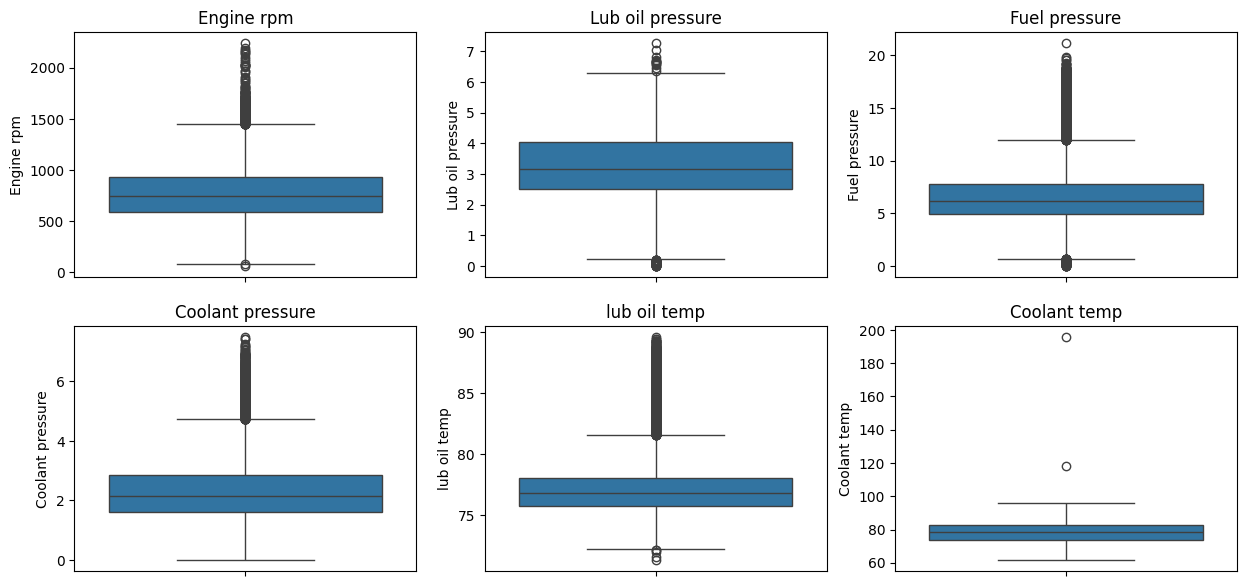

In [195]:
# Display the box plots
box_plots(df, 2, 3)

The data shows for most of the variables that there are significant outliers and indicates skewed data that is not normally distributed. Coolant temperature is the only feature that doesn't initially display skew and only has two outliers.

The next step is to visualise the data in histograms to determine if the data aligns with a normal distribution.

In [196]:
def hist_plots(df, n_row, n_col):
    """
    Displays a histogram for each feature in a DataFrame

    Parameters:
    - df (pd.DataFrame): The dataframe for analysis
    - n_row (int): Desired number of rows of subplots 
    - n_col (int): Desired number of columns of subplots 
    """
    # Set subplot number
    plot_num=1

    plt.figure(figsize=(15, 12))

    # Plot a hist plot for each variable
    for column in df:
        plt.subplot(n_row, n_col, plot_num)
        sns.histplot(df[column])
        plt.title(column)

        # Change the subplot number for next plot
        plot_num += 1
        
    # View the plot.
    plt.show()

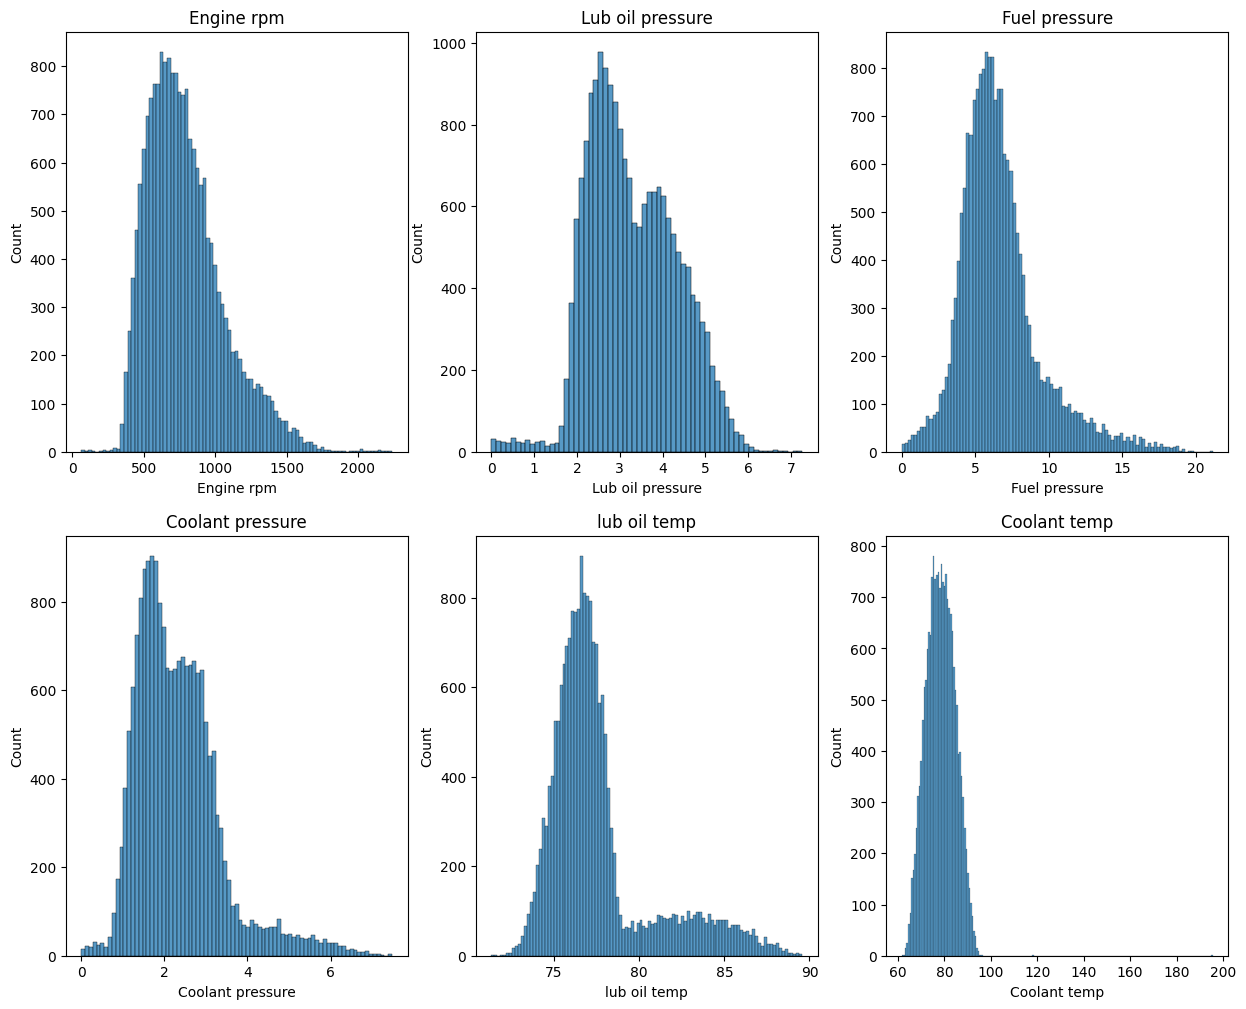

In [197]:
# Display the hist plots
hist_plots(df, 2, 3)

As inferred from the boxplots, all of the geatures except for coolant temperature display a non-normal distribution, with significant right skew.

After visualisation, the next step is to calculate the interquartile range for each of the features and identify instances where the data falls outside of this range. These instances will then be classified as an outlier. We can then create a binary column for each feature displaying whether or not the data is an outlier.

In [198]:
def iqr(df):
  """
  Calculates and displays the interquartile range for values of a specified column/feature and creates a binary column displaying which data points lie outside that range.
  Args:
      df (pd.DataFrame): The DataFrame that is being analysed.
  """

  for column in df:
      # Sort the dataframe by the values of the feature being analysed
      sorted = df[column].sort_values()
        
      # Calculate the quantiles.
      q1 = sorted.quantile(0.25)
      q3 = sorted.quantile(0.75)
    
      # View the output.
      print(f"The value of Q1 for {column} is: {q1:.2f}")
      print(f"The value of Q3 for {column} is: {q3:.2f}")
    
      # Compute the IQR.
      iqr = q3 - q1
      print(f"The value of IQR is: {iqr:.2f}")
    
      # Calculate the upper and lower limits.
      lower = q1-1.5*iqr
      upper = q3+1.5*iqr
      print(f"Upper limit for {column}: {upper:.2f}")
      print(f"Lower limit for {column}: {lower:.2f}\n")
    
      # Populate a binary column for each feature indicating whether the data falls outside of the IQR
      df[f"{column} outlier"] = df[column].apply(lambda x: int(x < lower) | int(x > upper))

In [199]:
iqr(df)

The value of Q1 for Engine rpm is: 593.00
The value of Q3 for Engine rpm is: 934.00
The value of IQR is: 341.00
Upper limit for Engine rpm: 1445.50
Lower limit for Engine rpm: 81.50

The value of Q1 for Lub oil pressure is: 2.52
The value of Q3 for Lub oil pressure is: 4.06
The value of IQR is: 1.54
Upper limit for Lub oil pressure: 6.36
Lower limit for Lub oil pressure: 0.21

The value of Q1 for Fuel pressure is: 4.92
The value of Q3 for Fuel pressure is: 7.74
The value of IQR is: 2.83
Upper limit for Fuel pressure: 11.99
Lower limit for Fuel pressure: 0.67

The value of Q1 for Coolant pressure is: 1.60
The value of Q3 for Coolant pressure is: 2.85
The value of IQR is: 1.25
Upper limit for Coolant pressure: 4.72
Lower limit for Coolant pressure: -0.27

The value of Q1 for lub oil temp is: 75.73
The value of Q3 for lub oil temp is: 78.07
The value of IQR is: 2.35
Upper limit for lub oil temp: 81.59
Lower limit for lub oil temp: 72.21

The value of Q1 for Coolant temp is: 73.90
The valu

In [200]:
# Visualise the data set
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine rpm outlier,Lub oil pressure outlier,Fuel pressure outlier,Coolant pressure outlier,lub oil temp outlier,Coolant temp outlier
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0,0,0,0,0,0
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,0,0,0,1,0,0
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0,0,0,0,1,0
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,0,0,0,0,0,0
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,0,0,0,0,0,0


Now that we have a column for each instance of data that indicates which metrics are showing anomalous activity, we can create a new feature that displays the total number of metrics for each row that are listed as an anomaly. Ships with more than one metric showing anomalous activity present stronger evidence of a potential fault and indicate that these ships are more likely to be in need of servicing.

In [201]:
# For each row, calculate the number of features that show anomalous activity
df["Total outliers"] = df.iloc[:,6:].sum(axis=1)
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine rpm outlier,Lub oil pressure outlier,Fuel pressure outlier,Coolant pressure outlier,lub oil temp outlier,Coolant temp outlier,Total outliers
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0,0,0,0,0,0,0
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,0,0,0,1,0,0,1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0,0,0,0,1,0,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,0,0,0,0,0,0,0
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,0,0,0,0,0,0,0


As we are aware from industry knowledge, the number of ships that are in potential need of servicing lies within the range of 1-5%. By calculating the proportion of ships that indicate outliers in a certain number of features, we can set the threshold for when ships should be called in for inspection and maintenance.

In [202]:
# Display the proportion of data points that show anomalous activity in multiple features
num_rows = df.shape[0]

for x in range(1,7):
  anomaly_count = (df["Total outliers"] >= x).sum()
  anomaly_percentage = anomaly_count / num_rows * 100
  print(f"The number of anomalies where {x}+ outliers have been identified:",anomaly_count, "which is ", anomaly_percentage.round(2), "% of the total data.")

The number of anomalies where 1+ outliers have been identified: 4636 which is  23.73 % of the total data.
The number of anomalies where 2+ outliers have been identified: 422 which is  2.16 % of the total data.
The number of anomalies where 3+ outliers have been identified: 11 which is  0.06 % of the total data.
The number of anomalies where 4+ outliers have been identified: 0 which is  0.0 % of the total data.
The number of anomalies where 5+ outliers have been identified: 0 which is  0.0 % of the total data.
The number of anomalies where 6+ outliers have been identified: 0 which is  0.0 % of the total data.


From the above analysis, ships with 2+ outliers in the shipping telemetry data represent 2.16% of the total data. This falls within the range indicated of 1-5% suspected ships in need of inspection/servicing so this seems like a sensible threshold to set. All ships with 2+ outliers should be recalled for inspection and have been filtered out below.

In [203]:
# Filter for the ships in need of inspection
inspection_df = df[df["Total outliers"] >= 2]

## Anomaly detection: machine learning methods

Beyond the statistical methods for identifying outliers there are also a range of more sophisticated machine learning models available. For this project we will use One-class SVM and Isolation Forest models as alternatives for outlier detection.

### One-class SVM

One-class SVM is an unsupervised learning technique that is typically used for anomaly detection. One-class SVM focuses on one class and separates observations belonging to that class from other observations in an unlabelled data set. It maps the input data into a higher-dimensional feature space by employing a kernel function. A hyperplane (decision boundary) that encloses most of the normal observations but maintains a maximum margin between the hyperplane and observations is then chosen. Observations that fall outside the boundaries are classified as anomalies. 

In [204]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

The clean dataframe will be reloaded as it was transformed in the previous stage. The features will also be scaled ahead of modelling to prevent the different scales of measurements of the various features having an undue impact on the inferences made by the model

In [205]:
# Scale data for better SVM performance
df = pd.read_csv('data/ship-data.csv')

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [206]:
# Example usage with a pre-defined One-Class SVM model
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.02)
model.fit(df_scaled)

,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,tol,0.001
,nu,0.02
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [207]:
# Predict the class (normal or anomaly).
y_pred = model.predict(df_scaled)

anomaly_count = (y_pred == -1).sum()
anomaly_percentage = anomaly_count / num_rows * 100
print(anomaly_percentage.round(2))

3.21


The number of anomalies identified by the model is within the 1-5% range identified at the start of the project, hence we can assume that the results are reasonable. The hyperparameters 'gamma' and 'nu' were tuned to find a model that produced results within the desired range.

The next step is to visualise the data and the outliers identified. Since the dataset has six features, the model will be identifying outliers in a six-dimensional space. As this cannot be visualised, we will reduce the dimensionality of the data using Principal Component Analysis (PCA). This allows us to visualise the data in two dimensions while retaining a distance between the observations.

In [208]:
def plot_ocsvm_with_pca(X, nu=0.02, kernel="rbf", gamma=0.5):
    """
    Trains a One-Class SVM on high-dimensional data and visualizes
    the decision boundary and outliers after PCA dimensionality reduction.

    Parameters:
    - X: numpy array or DataFrame with shape (n_samples, n_features)
    - nu: An upper bound on the fraction of training errors (outliers)
    - kernel: Kernel type for SVM
    - gamma: Kernel coefficient
    """

    # Fit One-Class SVM
    model = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
    model.fit(X)

    # Predict labels (-1: outlier, 1: inlier)
    preds = model.predict(X)

    # Reduce to 2D with PCA for plotting
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Create grid for decision boundary
    xx, yy = np.meshgrid(
        np.linspace(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1, 500),
        np.linspace(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1, 500)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Project grid back to original feature space (approximate inverse PCA)
    grid_original = pca.inverse_transform(grid)
    
    # Compute decision function
    Z = model.decision_function(grid_original)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')

    # Plot inliers and outliers
    plt.scatter(X_2d[preds == 1, 0], X_2d[preds == 1, 1], c='white', s=20, edgecolors='k', label='Inliers')
    plt.scatter(X_2d[preds == -1, 0], X_2d[preds == -1, 1], c='red', s=20, edgecolors='k', label='Outliers')

    plt.title("One-Class SVM with PCA-reduced Data")
    plt.legend()
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

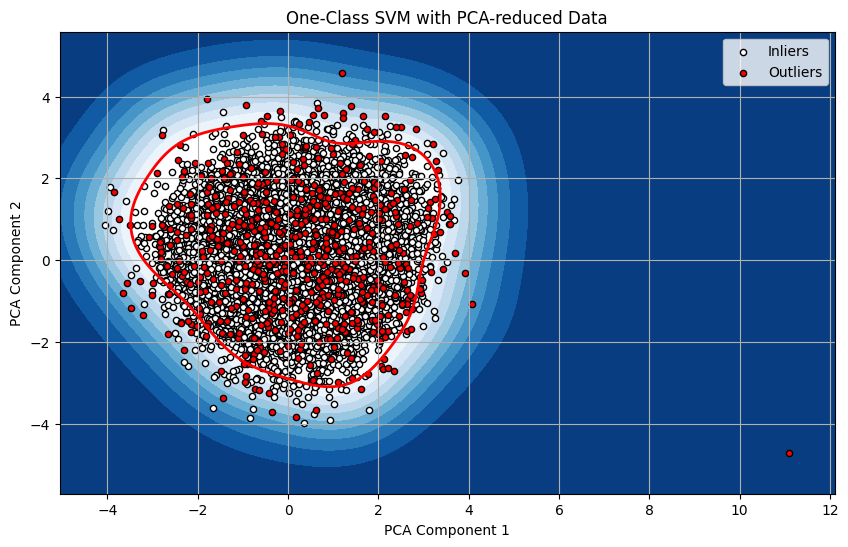

In [209]:
plot_ocsvm_with_pca(df_scaled)

The plot shows the distrubution of the PCA components and the decision boundary. The PCA compression can distort the spatial relationships meaning that point that looks "inside the boundary" in 2D might be outside in the full 6D space, hence why some outliers appear to sit inside the decision boundary.

The ships identified as needing maintenance or inspection are then filtered for below.

In [210]:
df["anomaly"] = y_pred
anomaly_df = df[df["anomaly"] == -1]

anomaly_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
17,1312,5.963439,7.563578,5.931953,77.738876,88.661972,-1
149,1193,3.669258,7.845989,1.229372,85.322621,67.009104,-1
189,252,2.759883,11.209682,2.362125,75.691300,72.197108,-1
244,936,4.305496,4.956328,3.000931,75.204754,93.890816,-1
245,848,4.105940,4.408648,2.524463,78.278250,65.001209,-1


### Isolation Forest

Isolation forest is an ensemble decision tree method. The fundamental assumption is that anomalies are few in number and they are different, which makes them easier to isolate from the normal data points. Furthermore, since they are different from the normal points, they can be isolated in fewer steps or partitions of a decision tree. It is expected that anomalies would generally be closer to the root node than the normal data points. 

In [211]:
from sklearn.ensemble import IsolationForest

Again, the dataframe will be reloaded to avoid any contamination with previous transformations. There is no need to scale the data for decision tree models, so this step is skipped.

In [212]:
# Import dataframe
df = pd.read_csv('data/ship-data.csv')

The isolation forest is initialised below. The hyperparamters chosen are 100 for the number of trees in the forest and 2.5% proportion of outliers in the data, which is within our desired range of 1-5%.

In [213]:
# Initialize and fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.025, random_state=42)
iso_forest.fit(df)

,n_estimators,100
,max_samples,'auto'
,contamination,0.025
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [214]:
scores_pred = iso_forest.decision_function(df)

# Predict the anomalies (1 for not anomaly, -1 for anomaly).
y_pred = iso_forest.predict(df)

# Add anomaly column to DataFrame.
df['anomaly'] = y_pred

In [215]:
# Display anomalies in the DataFrame.
only_anomalies = df[df["anomaly"] == -1]

anomaly_percentage = only_anomalies.shape[0] / num_rows * 100
print(anomaly_percentage)

2.503199385717942


As shown above the proportion of outliers detected by the Isolation Forest model is 2.5%, as dictated by the chosen hyperparameters. This is within our expected rane, hence the results can be assumed to be reasonable.

Again, the next step is to visualise the data and the outliers identified. PCA will again be necessary to be able to visualise the data in two dimensions.

In [216]:
def plot_isolation_forest_with_pca(X, contamination=0.025, n_estimators=100, random_state=42):
    """
    Trains an Isolation Forest on high-dimensional data and visualizes
    the decision boundary and outliers after PCA dimensionality reduction.

    Parameters:
    - X: numpy array or DataFrame with shape (n_samples, n_features)
    - contamination: Proportion of outliers in the data
    - n_estimators: Number of trees in the forest
    - random_state: For reproducibility
    """

    # Fit Isolation Forest
    model = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=random_state)
    model.fit(X)

    # Predict labels (-1: outlier, 1: inlier)
    preds = model.predict(X)

    # Reduce to 2D with PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Create mesh grid in 2D PCA space
    xx, yy = np.meshgrid(
        np.linspace(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1, 500),
        np.linspace(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1, 500)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Project grid back to original space
    grid_original = pca.inverse_transform(grid)

    # Compute anomaly score (higher means more abnormal)
    Z = model.decision_function(grid_original)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot inliers and outliers
    plt.scatter(X_2d[preds == 1, 0], X_2d[preds == 1, 1], c='white', s=20, edgecolors='k', label='Inliers')
    plt.scatter(X_2d[preds == -1, 0], X_2d[preds == -1, 1], c='red', s=20, edgecolors='k', label='Outliers')

    plt.title("Isolation Forest with PCA-reduced Data")
    plt.legend()
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

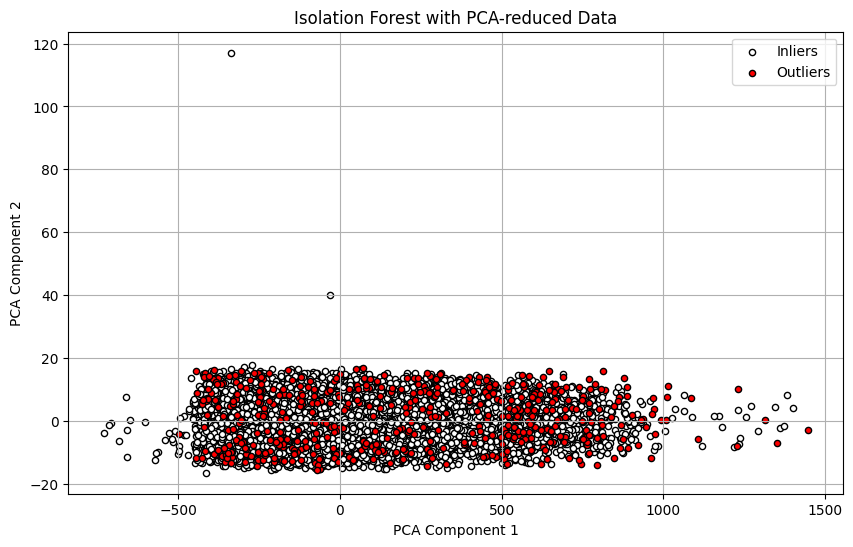

In [217]:
plot_isolation_forest_with_pca(df)

The plot above shows the outliers highlighted in red. The visualisation of the data is unusual as it shows data points that have got drastically different PCA components not being labelled as outliers. As with One-class SVM, PCA is an approximation of the data in two dimensional space and as such does not always accurately show the real distance between two observations.

## Conclusions

As shown above, anomalous engine activity has been identified using three different methods: interquartile range, One-class SVM and Isolation Forest. All three methods were able to come up with a list of ships that exhibitted signs of unusual activity within the 1-5% range identified as reasonable at the start of the project. PCA provides a useful method of visualisation for the machine learning methods, however some of the results are not immediately clear due to the approximation involved in representing a higher dimensional space in two dimensions.